#### Before we get started, make sure you install `deltalake` in your environment.

In [129]:
%pip install humanize

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [130]:
%pip install more-itertools

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [141]:
import polars as pl
import polars.selectors as cs
from glob import glob
import re
from functools import reduce
import requests, zipfile, os, shutil, io
from humanize import naturalsize
from pathlib import Path
from toolz import pipe
from toolz.curried import map
from more_itertools import consume

## The Principle of Locality.

<img src="./img/locality.png" width="800">

We can leverage the behavior of the operating system (OS)--in particular the loading of chucks of data in proximity and keeping that data in memory for a time--by partitioning our data so that similar data is stored together.

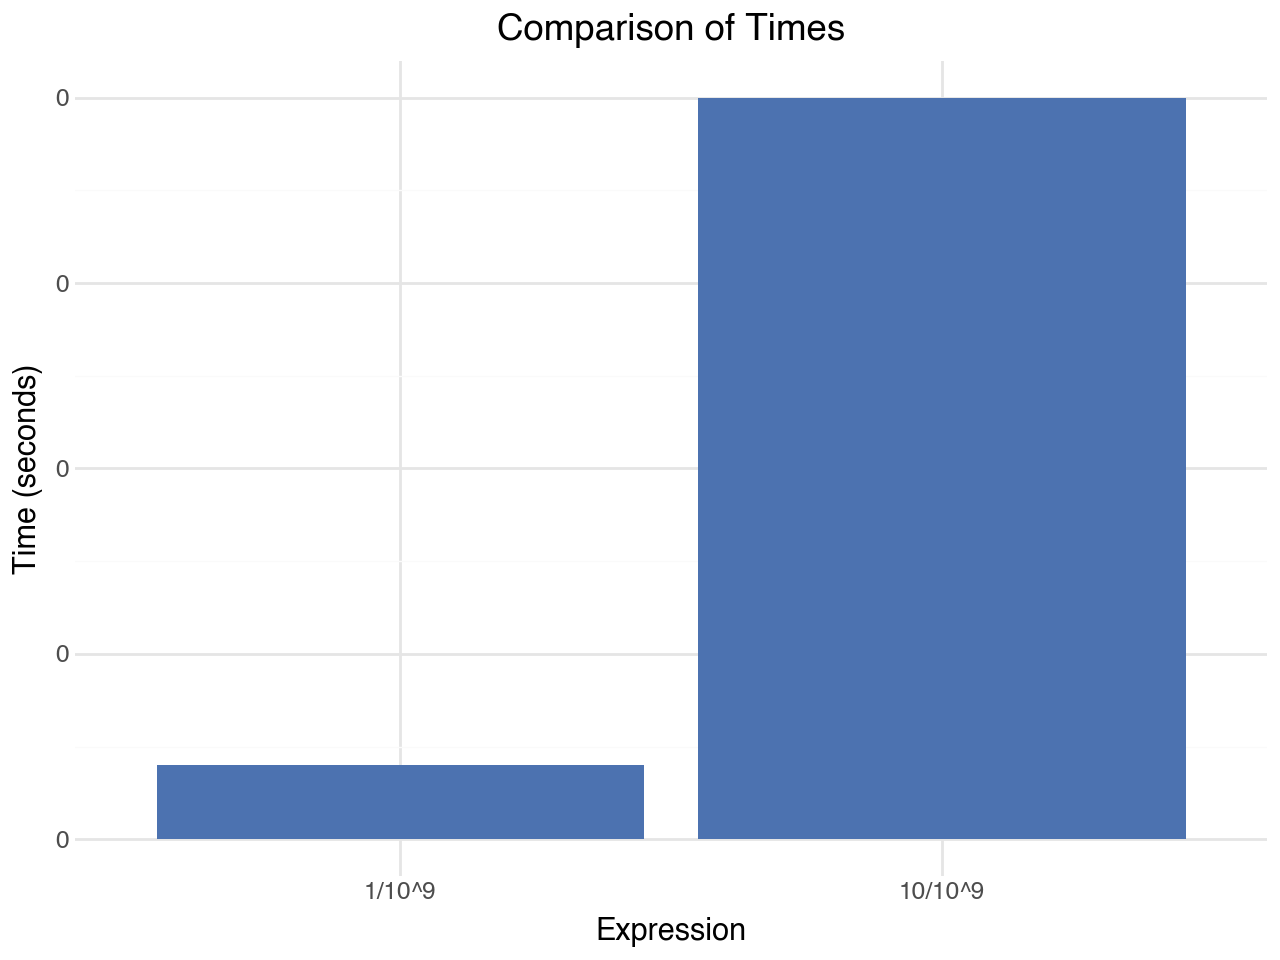

In [133]:
import plotnine as p9

# Create the DataFrame with the times
times = [
    # 10/100,
    # 80/10**9,
    10/10**9,
    1/10**9,
 ]
labels = [
    # '10/100',
    # '80/10^9',
    '10/10^9',
    '1/10^9',
 ]
times_df = pl.DataFrame({
    'time': times,
    'label': labels,
})

# Convert to pandas for plotnine
times_pd = times_df.to_pandas()

# Plot bar chart
(p := 
    p9.ggplot(times_pd, p9.aes(x='label', y='time')) +
    p9.geom_bar(stat='identity', fill='#4C72B0') +
    p9.theme_minimal() +
    p9.labs(title='Comparison of Times', x='Expression', y='Time (seconds)')
)

# Reading and writing parquet and delta lake tables with Polars

In this lecture, we will explore lazy reading and writing of parquet and delta lake tables with Polars. We will also discuss strategies for joining large datasets efficiently.
2. Understand the relationship between tables (one-to-one; one-to-many; many-to-many), and
3. Pick a join type and investigate key mismatches.

#### Download the Uber data files from FiveThirtyEight's GitHub repository

We will use the following big(ish) data files containing Uber trip data in New York City from 2014 to 2017. The files are stored in CSV format on FiveThirtyEight's GitHub repository. Let's create a list of the URLs for these files and automatically download them.

#### Download and unzip the 2015 data

In [135]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}


In [142]:
uber_538_zip_url = "https://github.com/fivethirtyeight/uber-tlc-foil-response/raw/refs/heads/master/uber-trip-data/uber-raw-data-janjune-15.csv.zip"

try:
    r = requests.get(uber_538_zip_url, headers=headers)
    print(f'Downloading {uber_538_zip_url}')
    assert r.ok
    z = zipfile.ZipFile(io.BytesIO(r.content))
    print(f'Unzipping {uber_538_zip_url}')
    z.extractall("./data")
    print('Download and unzip was successful')
except Exception as e:
    print(e)


Unzipping https://github.com/fivethirtyeight/uber-tlc-foil-response/raw/refs/heads/master/uber-trip-data/uber-raw-data-janjune-15.csv.zip
Download and unzip was successful
Download and unzip was successful


#### Download the 2014 data (no need to unzip)

In [143]:
(uber_files_names :=
   [
   'taxi-zone-lookup.csv',
   'uber-raw-data-apr14.csv',
   'uber-raw-data-aug14.csv',
   'uber-raw-data-jul14.csv',
   'uber-raw-data-jun14.csv',
   'uber-raw-data-may14.csv',
   'uber-raw-data-sep14.csv',
   ]
)

['taxi-zone-lookup.csv',
 'uber-raw-data-apr14.csv',
 'uber-raw-data-aug14.csv',
 'uber-raw-data-jul14.csv',
 'uber-raw-data-jun14.csv',
 'uber-raw-data-may14.csv',
 'uber-raw-data-sep14.csv']

In [144]:
(uber_urls :=
  [f'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/refs/heads/master/uber-trip-data/{name}'
   for name in uber_files_names]
)

['https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/refs/heads/master/uber-trip-data/taxi-zone-lookup.csv',
 'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/refs/heads/master/uber-trip-data/uber-raw-data-apr14.csv',
 'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/refs/heads/master/uber-trip-data/uber-raw-data-aug14.csv',
 'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/refs/heads/master/uber-trip-data/uber-raw-data-jul14.csv',
 'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/refs/heads/master/uber-trip-data/uber-raw-data-jun14.csv',
 'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/refs/heads/master/uber-trip-data/uber-raw-data-may14.csv',
 'https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/refs/heads/master/uber-trip-data/uber-raw-data-sep14.csv']

In [145]:
for fn, url in zip(uber_files_names, uber_urls):
    try:
        print(f"Downloading {url}")
        r = requests.get(url, headers=headers)
        assert r.ok
        with open(f'./data/{fn}', 'w') as out:
            print(f"Writing {fn} to the data folder")
            out.write(r.content.decode('utf-8'))
    except Exception as e:
        print(f"Problem downloading {url}: {e}\n\n")

Writing taxi-zone-lookup.csv to the data folder
Writing uber-raw-data-apr14.csv to the data folder
Writing uber-raw-data-apr14.csv to the data folder
Writing uber-raw-data-aug14.csv to the data folder
Writing uber-raw-data-aug14.csv to the data folder
Writing uber-raw-data-jul14.csv to the data folder
Writing uber-raw-data-jul14.csv to the data folder
Writing uber-raw-data-jun14.csv to the data folder
Writing uber-raw-data-jun14.csv to the data folder
Writing uber-raw-data-may14.csv to the data folder
Writing uber-raw-data-may14.csv to the data folder
Writing uber-raw-data-sep14.csv to the data folder
Writing uber-raw-data-sep14.csv to the data folder


#### Inspect the files and their sizes

In [146]:
{p: naturalsize(os.path.getsize(p))
 for p in glob('./data/[tu]*.csv')
}

{'./data/taxi-zone-lookup.csv': '7.7 kB',
 './data/uber-raw-data-janjune-15.csv': '551.7 MB',
 './data/uber-raw-data-apr14.csv': '26.1 MB',
 './data/uber-raw-data-aug14.csv': '38.3 MB',
 './data/uber-raw-data-sep14.csv': '47.5 MB',
 './data/uber-raw-data-jul14.csv': '36.9 MB',
 './data/uber-raw-data-jun14.csv': '30.7 MB',
 './data/uber-raw-data-may14.csv': '30.2 MB'}

## Topic 1: Reading and writing Parquet files with Polars

First, we will read the CSV files as lazy Polars DataFrames and write them out as Parquet files. Parquet is a columnar storage file format that is optimized for big data processing. It is more efficient than CSV in terms of both storage space and read/write speed.

### Example - Writing the April 2014 data to Parquet

In [148]:
apr_path = 'data/uber-raw-data-apr14.csv'

(apr14_query :=
  pl.scan_csv(apr_path)
).limit(5).collect()

Date/Time,Lat,Lon,Base
str,f64,f64,str
"""4/1/2014 0:11:00""",40.769,-73.9549,"""B02512"""
"""4/1/2014 0:17:00""",40.7267,-74.0345,"""B02512"""
"""4/1/2014 0:21:00""",40.7316,-73.9873,"""B02512"""
"""4/1/2014 0:28:00""",40.7588,-73.9776,"""B02512"""
"""4/1/2014 0:33:00""",40.7594,-73.9722,"""B02512"""


#### Writing an unpartitioned Parquet file

In [149]:
apr_out_path = apr_path.replace('csv', 'parquet')

apr14_query.sink_parquet(apr_out_path, mkdir=True)

#### Writing a partitioned Parquet file

In [150]:
apr_partitioned_out_path = apr_path.replace('.csv', '_by_base.parquet')

(apr14_query
 .sink_parquet(pl.PartitionByKey(apr_partitioned_out_path,
                                 by="Base"),
                                 mkdir=True
              )
)

#### Exploring the Parquet files we just wrote

**Note.** The Parquet files are smaller than the original CSV files because Parquet uses compression and is a more efficient storage format.

In [151]:
# Need to work a little harder to get the content of a partitioned parquet file, which is really a folder
folder_size = lambda folder: sum(p.stat().st_size for p in Path(folder).rglob('*'))

{p: naturalsize(folder_size(p) if os.path.isdir(p) else os.path.getsize(p))
 for p in glob('./data/*apr14*')
}

{'./data/uber-raw-data-apr14_by_base.parquet': '2.8 MB',
 './data/uber-raw-data-apr14.parquet': '2.8 MB',
 './data/uber-raw-data-apr14.csv': '26.1 MB'}

### Example - Reading Parquet files with Polars

#### Scanning an unpartitioned Parquet file

In [152]:
(pl.scan_parquet('data/uber-raw-data-apr14.parquet')
 .limit(10)
 .collect()
)

Date/Time,Lat,Lon,Base
str,f64,f64,str
"""4/1/2014 0:11:00""",40.769,-73.9549,"""B02512"""
"""4/1/2014 0:17:00""",40.7267,-74.0345,"""B02512"""
"""4/1/2014 0:21:00""",40.7316,-73.9873,"""B02512"""
"""4/1/2014 0:28:00""",40.7588,-73.9776,"""B02512"""
"""4/1/2014 0:33:00""",40.7594,-73.9722,"""B02512"""
"""4/1/2014 0:33:00""",40.7383,-74.0403,"""B02512"""
"""4/1/2014 0:39:00""",40.7223,-73.9887,"""B02512"""
"""4/1/2014 0:45:00""",40.762,-73.979,"""B02512"""
"""4/1/2014 0:55:00""",40.7524,-73.996,"""B02512"""


#### Scanning a partitioned Parquet file

In [153]:
(pl.scan_parquet('data/uber-raw-data-apr14_by_base.parquet')
 .limit(10)
 .collect()
)

Date/Time,Lat,Lon,Base
str,f64,f64,str
"""4/1/2014 0:11:00""",40.769,-73.9549,"""B02512"""
"""4/1/2014 0:17:00""",40.7267,-74.0345,"""B02512"""
"""4/1/2014 0:21:00""",40.7316,-73.9873,"""B02512"""
"""4/1/2014 0:28:00""",40.7588,-73.9776,"""B02512"""
"""4/1/2014 0:33:00""",40.7594,-73.9722,"""B02512"""
"""4/1/2014 0:33:00""",40.7383,-74.0403,"""B02512"""
"""4/1/2014 0:39:00""",40.7223,-73.9887,"""B02512"""
"""4/1/2014 0:45:00""",40.762,-73.979,"""B02512"""
"""4/1/2014 0:55:00""",40.7524,-73.996,"""B02512"""


## Topic 2: Reading and writing Delta Lake tables with Polars

While parquet is a great file format for big data processing, Delta Lake is a storage layer that brings ACID transactions to big data workloads. It is built on top of Parquet and provides features such as schema enforcement, time travel, and data versioning.

In particular, Delta Lake is useful for building data lakes that require reliable data ingestion and processing, such as combining streaming and batch data processing across multiple files.

### Important Notes on writing Delta Lake tables

1. **<font color='orange'>Install deltalake.</font>** In polars, lazy DataFrames can only be written to Delta Lake tables if the `deltalake` package is installed in your Python environment. If you attempt to write a lazy DataFrame to a Delta Lake table without this package, you will encounter an error.
2. **<font color='orange'>collect then write delta.</font>** If your are using a lazy DataFrame and want to write it to a Delta Lake table, you must first collect it into a non-lazy DataFrame using the `.collect()` method. This is because the Delta Lake writing functionality in polars currently only supports non-lazy DataFrames.
3. **<font color='orange'>Streaming collection.</font>** When collecting a lazy dataframe for a large file, use `collect(engine='streaming')` to avoid memory issues.
4. **<font color='orange'>Writing modes.</font>** When writing to a Delta Lake table, you can specify the `mode` parameter to control how the data is written. The available modes are:
   - `"overwrite"`: Overwrites the existing data in the Delta Lake table.
   - `"append"`: Appends the new data to the existing data in the Delta Lake table.
   - `"ignore"`: Ignores the write operation if the Delta Lake table already exists.
   - `"error"`: Raises an error if the Delta Lake table already exists.

### Example 2 - Combining all the 2014 Uber data into a Delta Lake table

**Note.** When writing the delta table, we will use the `mode="overwrite"` on the first file then `mode="append"` on the subsequent files to combine all the data into a single Delta Lake table.

In [154]:
(uber_14_queries :=
 [pl.scan_csv(p)
  for p in glob('./data/uber*14.csv')
 ]

)

In [155]:
[q.limit(2).collect() for q in uber_14_queries ]

[shape: (2, 4)
 ┌──────────────────┬─────────┬──────────┬────────┐
 │ Date/Time        ┆ Lat     ┆ Lon      ┆ Base   │
 │ ---              ┆ ---     ┆ ---      ┆ ---    │
 │ str              ┆ f64     ┆ f64      ┆ str    │
 ╞══════════════════╪═════════╪══════════╪════════╡
 │ 4/1/2014 0:11:00 ┆ 40.769  ┆ -73.9549 ┆ B02512 │
 │ 4/1/2014 0:17:00 ┆ 40.7267 ┆ -74.0345 ┆ B02512 │
 └──────────────────┴─────────┴──────────┴────────┘,
 shape: (2, 4)
 ┌──────────────────┬─────────┬──────────┬────────┐
 │ Date/Time        ┆ Lat     ┆ Lon      ┆ Base   │
 │ ---              ┆ ---     ┆ ---      ┆ ---    │
 │ str              ┆ f64     ┆ f64      ┆ str    │
 ╞══════════════════╪═════════╪══════════╪════════╡
 │ 8/1/2014 0:03:00 ┆ 40.7366 ┆ -73.9906 ┆ B02512 │
 │ 8/1/2014 0:09:00 ┆ 40.726  ┆ -73.9918 ┆ B02512 │
 └──────────────────┴─────────┴──────────┴────────┘,
 shape: (2, 4)
 ┌──────────────────┬─────────┬──────────┬────────┐
 │ Date/Time        ┆ Lat     ┆ Lon      ┆ Base   │
 │ ---           

#### Writing a unpartitioned Delta Lake table from multiple CSV files

In [156]:
[ q.collect(engine='streaming')
   .write_delta('./data/uber14_example.delta',
                mode = 'overwrite' if i == 0 else 'append',
               )
 for i, q in enumerate(uber_14_queries)
]

[None, None, None, None, None, None]

#### Writing a partitioned Delta Lake table from multiple CSV files

In [157]:
[ q.collect(engine='streaming')
   .write_delta('./data/uber14_partitioned_example.delta',
                mode = 'overwrite' if i == 0 else 'append',
                delta_write_options = {'partition_by':'Base'}
               )
 for i, q in enumerate(uber_14_queries)
]

[None, None, None, None, None, None]

#### Exploring the Delta Lake tables we just wrote

In [158]:
# Need to work a little harder to get the content of a partitioned parquet file, which is really a folder
folder_size = lambda folder: sum(p.stat().st_size for p in Path(folder).rglob('*'))

{p: naturalsize(folder_size(p) if os.path.isdir(p) else os.path.getsize(p))
 for p in glob('./data/*.delta')
}

{'./data/uber14_partitioned_example.delta': '24.6 MB',
 './data/uber14_example.delta': '21.2 MB',
 './data/uber_2015_with_location.delta': '121.2 MB'}

### What's with all the `None`s?

The `write_delta` is a side-effecting/imperative method that does not return any value, so when we use a list comprehension to write multiple files, we get a list of `None`s.  While we almost always prefer a comprehension for its conciseness and composability, in this case we could also use a simple `for` loop to avoid the `None`s.

**Iverson's `for` Loop Law:** Only use `for` loops in three cases.

1. When an operation takes a long time and you want to track progress with `print`,
2. When the operation may fail and you want to handle exceptions with `try`/`except`, and
3. When you want to avoid the `None`s that result from using a list comprehension with a side-effecting function.

In [159]:
for i, q in enumerate(uber_14_queries):
    (q.collect(engine='streaming')
      .write_delta('./data/uber14_example.delta',
                   mode = 'overwrite' if i == 0 else 'append',
                  )
    )

In [160]:
for i, q in enumerate(uber_14_queries):
    (q.collect(engine='streaming')
     .write_delta('./data/uber14_partitioned_example.delta',
                  mode = 'overwrite' if i == 0 else 'append',
                  delta_write_options = {'partition_by':'Base'}
                 )
    )


#### ... or, `consume` the `None`s if you must use a comprehension

In [161]:
from toolz.curried import map
from more_itertools import consume

In [162]:
pipe(uber_14_queries,
     map(lambda q: q.collect(engine='streaming')
                    .write_delta('./data/uber14_example.delta',
                                mode = 'overwrite' if i == 0 else 'append',
                                )
        ),
    consume
)

## <font color="red">Exercise 6.4</font> - Partitioning by an external column

The 2015 Uber data contains an additional column called `Location`, which indicates the base location of the Uber driver. Information about the location can be found in the `taxi-zone-lookup.csv` file. 

**Tasks.**

1. Read the `taxi-zone-lookup.csv` file as a lazy Polars DataFrame (all DataFrames in a join must be lazy),

2. Build a query to read the 2015 Uber data as a lazy Polars DataFrame and joins the location data,

3. Test your query by collecting a small sample of the data, and

4. Write the full joined data as a partitioned Delta Lake table, partitioned by both the `Borough` and `Zone` columns. **Hint.** Pass a list of column names to the `partition_by` option in the `delta_write_options` parameter of the `write_delta` method.

In [107]:
# Your code here (add cells as needed)